## `Import Libraries`

In [ ]:
!pip install -q keras-tuner

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import tensorflow as tf
from kerastuner import RandomSearch

## `Get the Dataset`

In [ ]:
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## `Exploratory Data Analysis`

In [ ]:
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [ ]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# stats
df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# check NaNs
df.isna().sum().sort_values(ascending=False)

,0
cabin,687
age,177
embarked,2
passengerid,0
survived,0
pclass,0
name,0
sex,0
sibsp,0
parch,0


In [ ]:
# Columns that has NaNs
cols_nans = df.isna().any()[df.isna().any()].index.tolist()
cols_nans

['age', 'cabin', 'embarked']

### `Visualizing`

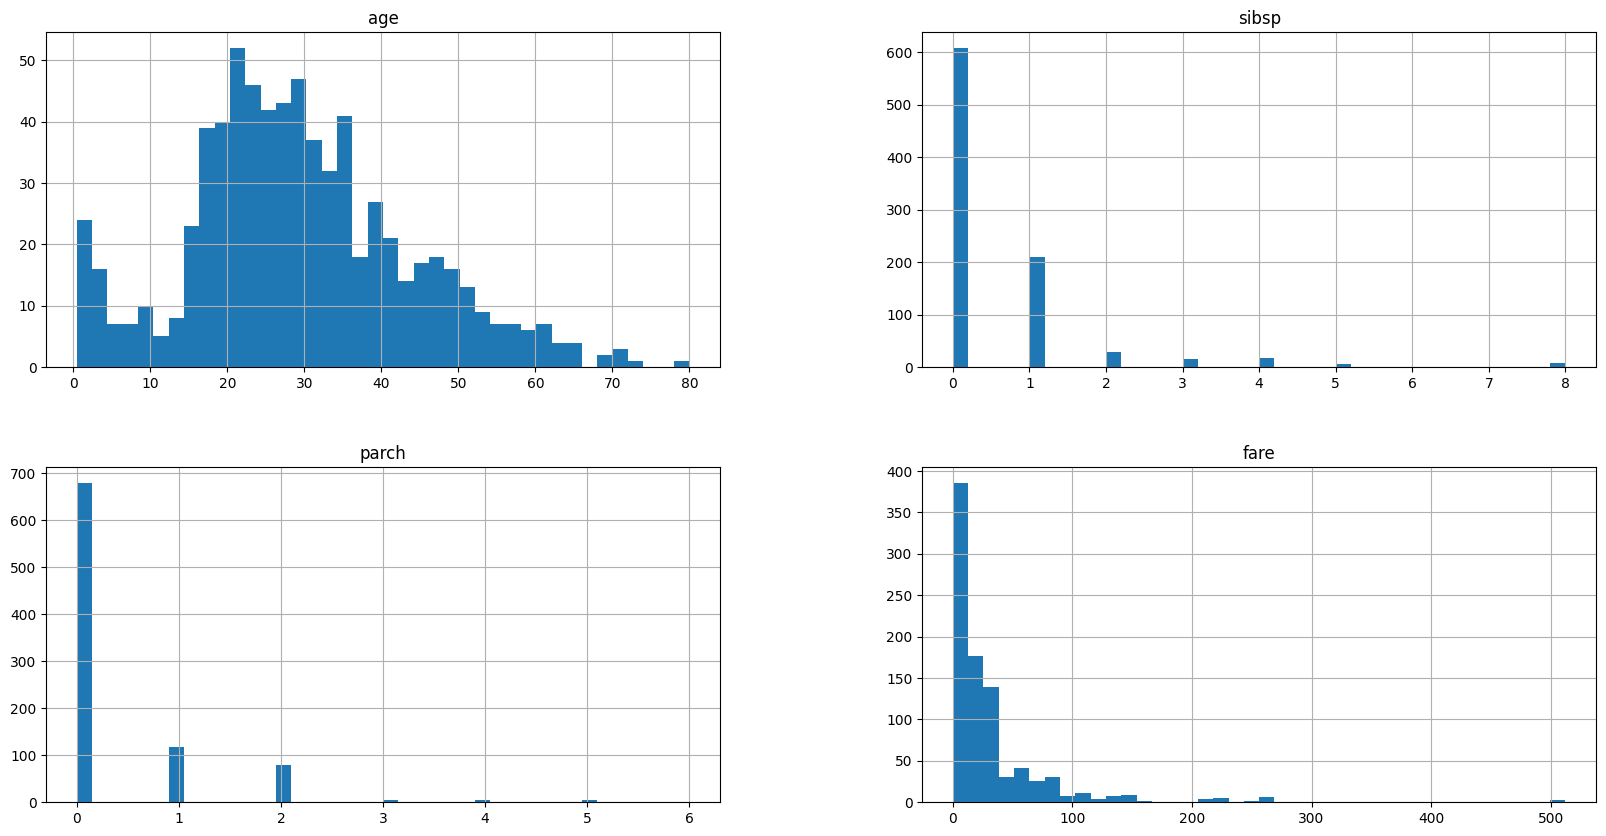

In [ ]:
# Numerical cols
# Let's work on some cols
num_cols = ['age', 'sibsp', 'parch', 'fare']
df[num_cols].hist(figsize=(20, 10), bins=40)
plt.show()

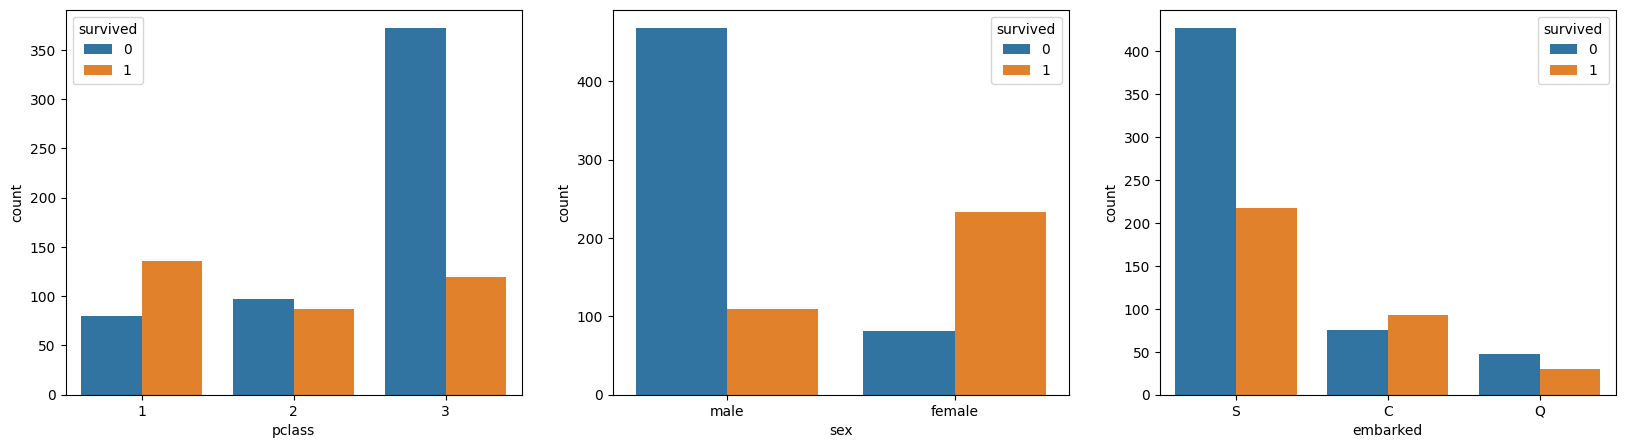

In [ ]:
# Categorical cols
# Let's work on these cols
categ_cols = ['pclass', 'sex', 'embarked']
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, col in enumerate(categ_cols):
    sns.countplot(data=df, x=col, ax=axes[i], hue="survived")
plt.show()

### `Feature Engineering`

In [ ]:
# Add 1 to add the passenger himself
# sibsp: siblings & spouses
# parch: parents & childerns
df['family_size'] = df['sibsp'] + df['parch'] + 1

# Make anothe column if he is alone or not
def is_alone(x):
  if x > 1:
    return 0
  else:
    return 1
# apply
df['is_alone'] = df['family_size'].apply(is_alone)

# Check now
df[['sibsp', 'parch', 'family_size', 'is_alone']].head()

,sibsp,parch,family_size,is_alone
0,1,0,2,0
1,1,0,2,0
2,0,0,1,1
3,1,0,2,0
4,0,0,1,1


## `Split the Dataset`

In [ ]:
# to X & y
choosen_features = ["pclass", "sex", "age", "sibsp", "parch", "family_size", "is_alone", "fare", "embarked"]
X = df[choosen_features]
y = df['survived']

# to train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [ ]:
# Check shapes
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print()
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (712, 9)
y_train shape (712,)

X_test shape (179, 9)
y_test shape (179,)


### `Preprocessing`

In [ ]:
# Let me divide into 3 subsets
num_cols = ["age", "fare"]
categ_cols = ["sex", "embarked"]
ready_cols = list(set(X_train.columns.tolist()) - set(num_cols) - set(categ_cols))

# check
print("Numerical cols: ", num_cols)
print("Categorical cols: ", categ_cols)
print("Ready cols: ", ready_cols)

Numerical cols:  ['age', 'fare']
Categorical cols:  ['sex', 'embarked']
Ready cols:  ['pclass', 'sibsp', 'family_size', 'is_alone', 'parch']


In [ ]:
# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categ_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('ohe', OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore"))
])

# Ready pipeline
read_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent"))
])


# Combine all
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('categ', categ_pipeline, categ_cols),
    ('ready', read_pipeline, ready_cols)
])


# Apply to all data
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

In [ ]:
# Check shapes again
print("X_train_final shape", X_train_final.shape)
print("y_train shape", y_train.shape)
print()
print("X_test_final shape", X_test_final.shape)
print("y_test shape", y_test.shape)

X_train_final shape (712, 10)
y_train shape (712,)

X_test_final shape (179, 10)
y_test shape (179,)


In [ ]:
MODELS_FOLDER_PATH = os.path.join(os.getcwd(), "models")
os.makedirs(MODELS_FOLDER_PATH, exist_ok=True)
joblib.dump(preprocessor, os.path.join(MODELS_FOLDER_PATH, "preprocessor.joblib"))

['/content/models/preprocessor.joblib']

## `Basic NN Model`

In [ ]:
X_train_final.shape[1]

10

In [ ]:
# Build basic NN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit model (with validation_split instead of validation-data: keeping the test dataset untouched)
history = model.fit(X_train_final, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.6323 - loss: 0.6677 - val_accuracy: 0.6783 - val_loss: 0.5903
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6902 - loss: 0.5750 - val_accuracy: 0.7483 - val_loss: 0.5408
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7237 - loss: 0.5429 - val_accuracy: 0.7483 - val_loss: 0.5109
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7666 - loss: 0.4877 - val_accuracy: 0.7972 - val_loss: 0.4814
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8045 - loss: 0.4629 - val_accuracy: 0.8112 - val_loss: 0.4689
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8091 - loss: 0.4456 - val_accuracy: 0.8112 - val_loss: 0.4653
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8098 - loss: 0.4422 - val_accuracy: 0.8252 - val_loss: 0.4596
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8390 - loss: 0.4113 - val_accuracy: 0.7972 

In [ ]:
# Evaluate on test
test_loss, test_acc = model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7882 - loss: 0.5990
Test Loss: 0.6496
Test Accuracy: 0.7709 %


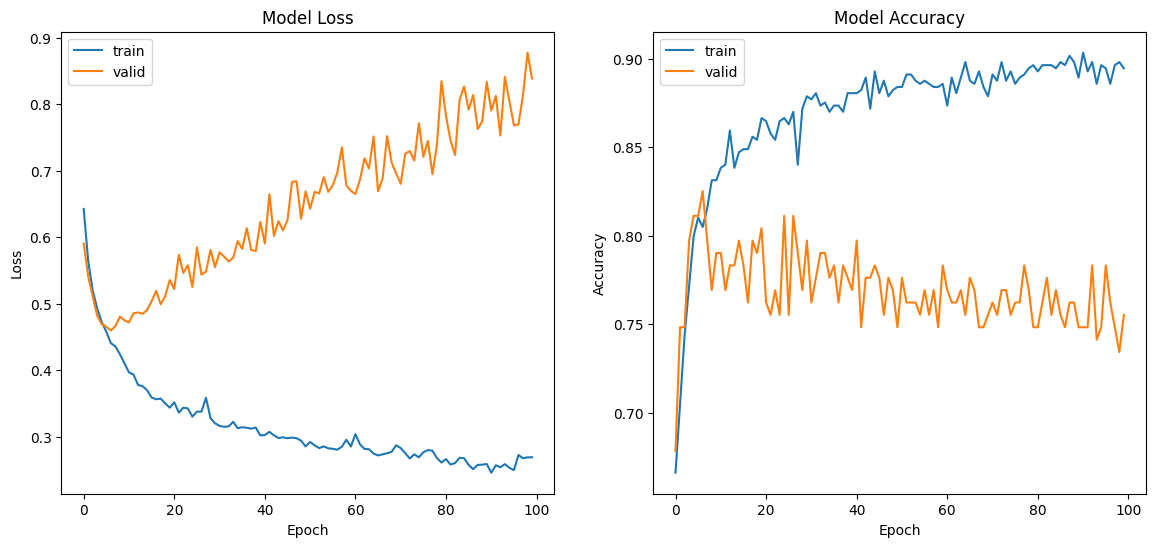

In [ ]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Enhancing Model`

In [ ]:
# Adding some Dropout layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dropout(0.5, seed=97),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=97),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=97),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Fit
history = model.fit(X_train_final, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.5174 - loss: 0.7229 - val_accuracy: 0.6014 - val_loss: 0.6526
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5890 - loss: 0.6743 - val_accuracy: 0.6084 - val_loss: 0.6372
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5904 - loss: 0.6569 - val_accuracy: 0.6014 - val_loss: 0.6291
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6185 - loss: 0.6518 - val_accuracy: 0.6643 - val_loss: 0.6203
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6533 - loss: 0.6173 - val_accuracy: 0.7063 - val_loss: 0.6137
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6352 - loss: 0.6077 - val_accuracy: 0.7273 - val_loss: 0.5989
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6541 - loss: 0.6093 - val_accuracy: 0.7203 - val_loss: 0.5878
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6808 - loss: 0.5914 - val_accuracy: 0.7343 -

In [ ]:
# Evaluate on test
test_loss, test_acc = model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8133 - loss: 0.4623
Test Loss: 0.4533
Test Accuracy: 0.8101 %


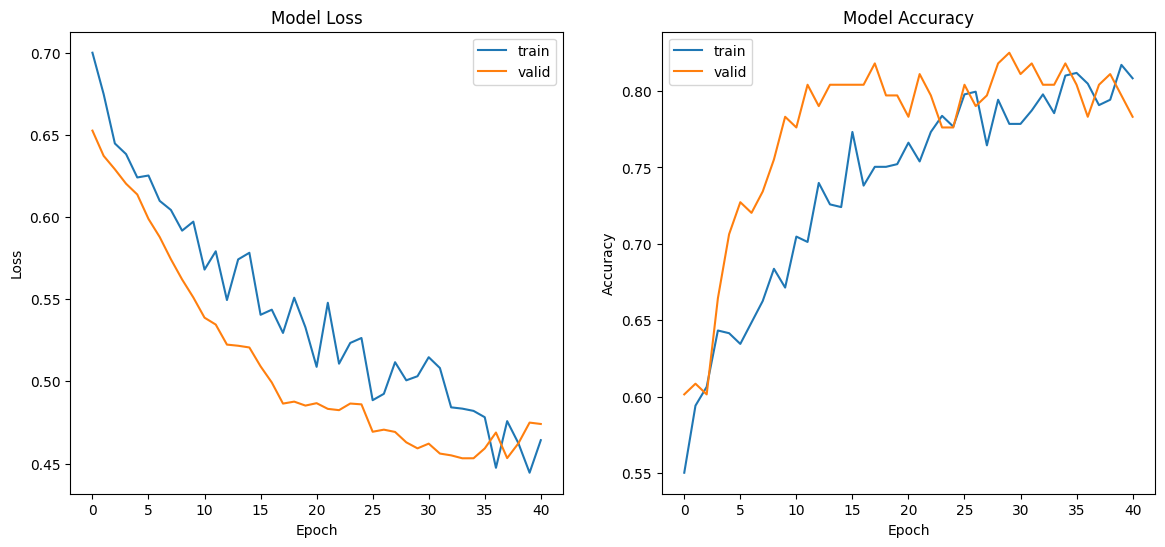

In [ ]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Enhancing the Model`

In [ ]:
# Try add a reguralizer l2
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01), input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer="l2"),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer="l2"),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Fit
history = model.fit(X_train_final, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.5775 - loss: 2.2603 - val_accuracy: 0.6364 - val_loss: 1.9812
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6678 - loss: 1.8888 - val_accuracy: 0.7133 - val_loss: 1.6874
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7236 - loss: 1.6078 - val_accuracy: 0.7133 - val_loss: 1.4489
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7343 - loss: 1.4087 - val_accuracy: 0.7483 - val_loss: 1.2640
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7557 - loss: 1.2291 - val_accuracy: 0.7832 - val_loss: 1.1201
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7813 - loss: 1.1187 - val_accuracy: 0.7972 - val_loss: 1.0134
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7969 - loss: 0.9785 - val_accuracy: 0.8042 - val_loss: 0.9323
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7593 - loss: 0.9324 - val_accuracy: 0.8042 -

In [ ]:
# Evaluate on test
test_loss, test_acc = model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7807 - loss: 0.5476
Test Loss: 0.5329
Test Accuracy: 0.8045 %


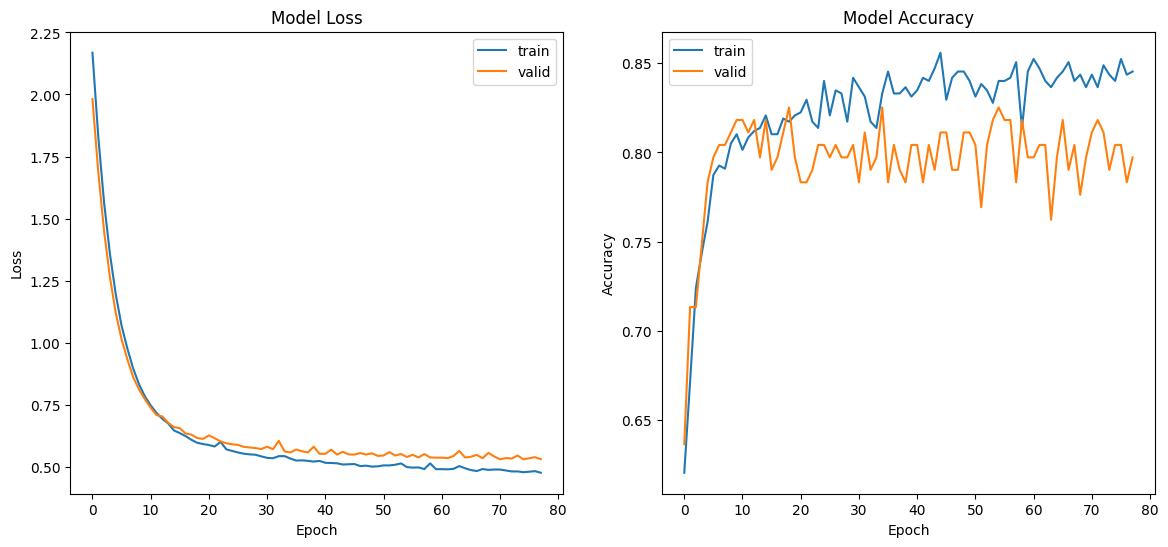

In [ ]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

----

## `Using Keras-Tuner`

In [ ]:
!pip install -q keras-tuner

In [ ]:
# A function to be called for HyperOpt
def build_model(hp):
    model = tf.keras.models.Sequential([

        # Input Layer (preferable)
        tf.keras.layers.Input(shape=(X_train_final.shape[1],)),

        # First Layer
        tf.keras.layers.Dense(units=hp.Int("units_1", min_value=32, max_value=256, step=32),
        activation="relu"),

        # Dropout
        tf.keras.layers.Dropout(hp.Float("dropout_1", min_value=0.0, max_value=0.5, step=0.1)),

        # Second Layer
        tf.keras.layers.Dense(units=hp.Int("units_2", min_value=32, max_value=256, step=32),
        activation="relu"),

        # Dropout
        tf.keras.layers.Dropout(hp.Float("dropout_2", min_value=0.0, max_value=0.5, step=0.1)),

        # Output Layer
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    return model

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [ ]:
# Setting up the Random Search
tuner = RandomSearch(hypermodel=build_model,
                     objective="val_accuracy",
                     max_trials=10,
                     executions_per_trial=2,
                     directory="hyperparam_tuning",
                     project_name="titanic_tuning",
                     seed=174)

In [ ]:
# Running tuner
tuner.search(X_train_final, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             )

Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.8181818127632141

Best val_accuracy So Far: 0.8321678042411804
Total elapsed time: 00h 02m 52s


In [ ]:
# Getting the best model configuration
best_model = tuner.get_best_models(num_models=1)[0]
best_model

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<Sequential name=sequential, built=True>

In [ ]:
# Evaluate on test
test_loss, test_acc = best_model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8026 - loss: 0.4977
Test Loss: 0.4796
Test Accuracy: 0.8045 %


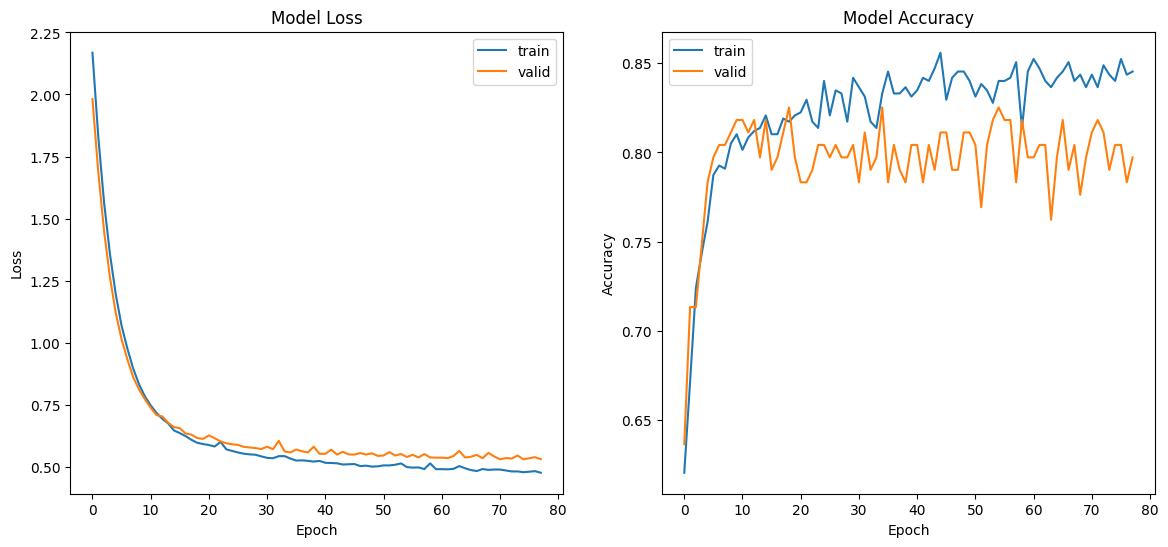

In [ ]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Save & Load the Best Model`

In [ ]:
# Saving the best model from hyperparameter tuning to a file
best_model.save(os.path.join(MODELS_FOLDER_PATH, "best_titanic_model.keras"))

In [ ]:
# Loading the saved model
model = tf.keras.models.load_model(os.path.join(MODELS_FOLDER_PATH, "best_titanic_model.keras"))

# Evaluate on test
test_loss, test_acc = best_model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8026 - loss: 0.4977 
Test Loss: 0.4796
Test Accuracy: 0.8045 %


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## `Inference`

In [ ]:
df.sample(10)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_size,is_alone
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S,2,0
65,66,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C,3,0
276,277,0,3,"Lindblom, Miss. Augusta Charlotta",female,45.0,0,0,347073,7.7500,NaN,S,1,1
702,703,0,3,"Barbara, Miss. Saiide",female,18.0,0,1,2691,14.4542,NaN,C,2,0
188,189,0,3,"Bourke, Mr. John",male,40.0,1,1,364849,15.5000,NaN,Q,3,0
76,77,0,3,"Staneff, Mr. Ivan",male,NaN,0,0,349208,7.8958,NaN,S,1,1
864,865,0,2,"Gill, Mr. John William",male,24.0,0,0,233866,13.0000,NaN,S,1,1
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C,3,0
807,808,0,3,"Pettersson, Miss. Ellen Natalia",female,18.0,0,0,347087,7.7750,NaN,S,1,1
219,220,0,2,"Harris, Mr. Walter",male,30.0,0,0,W/C 14208,10.5000,NaN,S,1,1


In [ ]:
# Let's try simulate inference

# Processing & Predictions
samples = df.sample(10, random_state=14)
samples_processed = preprocessor.transform(samples)
predictions = (model.predict(samples_processed) > 0.5).astype("int32")
predictions.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int32)

In [ ]:
results = pd.DataFrame({
    'Passenger_ID': samples["passengerid"],
    'Predicted': ['Survived' if pred == 1 else 'Not Survived' for pred in predictions.flatten()],
})

results

,Passenger_ID,Predicted
75,76,Not Survived
602,603,Not Survived
119,120,Not Survived
647,648,Not Survived
115,116,Not Survived
472,473,Survived
547,548,Not Survived
735,736,Not Survived
467,468,Not Survived
759,760,Survived


----